<a href="https://colab.research.google.com/github/fervo03/DFC_2020/blob/master/DFC605_Project_20200624.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from io import StringIO

path = '/content/drive/My Drive/Colab Notebooks/20200511_055550.txt'
fhand = open(path, 'rt')
trimed_data = 'Type Time C_price C_quantity C_direction Ask_price Ask_quantity Bid_price Bid_quantity Move_to*\n'

pd.set_option('display.max_row', 500)

In [ ]:
# 1단계 : TXT파일의 전문을 파싱하여 필요한 항목만으로 Dataframe 을 구성

pre_ask_p = 0

for line in fhand:
  time = line[-11:-2]
  data_type = line[:2]

  try:
    itime = int(time)
  except:
    continue

  if itime < 90000000 or itime > 152000000 :
    continue
  
  if data_type == 'A3':
    con_p = line[34:43]
    con_q = line[43:53]
    con_d = line[112:113]
    #ask_p = '000000000'
    #ask_q = '000000000000'
    #bid_p = '000000000'
    #bid_q = '000000000000'
    
  elif data_type == 'B6':
    con_p = '000000000'
    con_q = '0000000000'
    con_d = '0'
    ask_p = line[34:43]
    ask_q = line[52:64]
    bid_p = line[43:52]
    bid_q = line[64:76]

  if pre_ask_p == int(ask_p) :
    move_to = '0' 
  elif pre_ask_p > int(ask_p) :
    move_to = '1'
  elif pre_ask_p < int(ask_p) :
    move_to = '2'

  pre_ask_p = int(ask_p)
  
  trimed_line = data_type + ' ' + time + ' ' + con_p + ' ' + con_q + ' ' + con_d + ' ' + ask_p + ' ' + ask_q + ' ' + bid_p + ' ' + bid_q + ' ' + move_to
  trimed_data = trimed_data + trimed_line + "\n"

df = pd.read_csv(StringIO(trimed_data), sep = " ", error_bad_lines=False)
df

b'Skipping line 19: expected 10 fields, saw 11\n'


,Type,Time,C_price,C_quantity,C_direction,Ask_price,Ask_quantity,Bid_price,Bid_quantity,Move_to*
0,B6,90000254,0,0,0,30350,678,30300,1725,2
1,B6,90002010,0,0,0,30250,164,30200,199,1
2,B6,90003153,0,0,0,30200,20,30150,905,1
3,B6,90004199,0,0,0,30200,716,30150,742,0
4,B6,90005168,0,0,0,30150,81,30100,1040,1
...,...,...,...,...,...,...,...,...,...,...
33329,B6,151957740,0,0,0,29800,4726,29750,9993,0
33330,B6,151958420,0,0,0,29800,4726,29750,9993,0
33331,A3,151958487,29800,1,2,29800,4726,29750,9993,0
33332,A3,151958563,29800,152,2,29800,4726,29750,9993,0


In [ ]:
# 2단계 : Dataframe 으로 구성된 데이터를 가공하여 값을 추가
#    Move_to* : 호가변동 발생 
#    Pre_move* : 호가변동 발생 직전 20건 Row 표시
#    Impact* : 매도호가에 체결된 누적 체결량 (충격) 
#    BA_ratio* : 매수1호가 잔량 대비 매도1호가 잔량 (균형수준) 

cum_count = int()
cum_CQ = int()
cum_AQ = 1
df['Pre_move*'] = 0
df['Pre_move2*'] = 0
df['Impact*'] = 0

for i in df.index:
  if df.loc[i,'Move_to*'] == 2 :
    for k in range(20) :
      if df.loc[max(0,i-k-1), 'Move_to*'] != 0 :
        break
      df.loc[max(0,i-k-1), 'Pre_move2*'] = 4 - ( k // 5 ) 
      df.loc[max(0,i-k-1), 'Pre_move*'] = 1

  if df.loc[i, 'C_direction'] == 2 :
    cum_count = cum_count + 1
    cum_CQ = cum_CQ + df.loc[i, 'C_quantity']
    cum_AQ = cum_AQ + df.loc[i, 'Ask_quantity']
    
  if df.loc[i, 'Move_to*'] != 0 :
    cum_count = 0
    cum_CQ = 0
    cum_AQ = 1

  df.loc[i, 'Impact*'] = cum_CQ / cum_AQ * cum_count

df['BA_ratio*'] = df['Ask_quantity'] / df['Bid_quantity']
df['Impact*_log'] = np.log(df['Impact*'] * 10 + 1)
df['BA_ratio*_log'] = np.log(df['BA_ratio*'] * 10 + 1)

df.to_csv('df1.csv')
df2 = df[['Pre_move*','Pre_move2*','Impact*','BA_ratio*']]
df2.to_csv('df2.csv')

df

,Type,Time,C_price,C_quantity,C_direction,Ask_price,Ask_quantity,Bid_price,Bid_quantity,Move_to*,Pre_move*,Pre_move2*,Impact*,BA_ratio*,Impact*_log,BA_ratio*_log
0,B6,90000254,0,0,0,30350,678,30300,1725,2,0,0,0.000000,0.393043,0.000000,1.595427
1,B6,90002010,0,0,0,30250,164,30200,199,1,0,0,0.000000,0.824121,0.000000,2.223672
2,B6,90003153,0,0,0,30200,20,30150,905,1,0,0,0.000000,0.022099,0.000000,0.199666
3,B6,90004199,0,0,0,30200,716,30150,742,0,0,0,0.000000,0.964960,0.000000,2.365522
4,B6,90005168,0,0,0,30150,81,30100,1040,1,0,0,0.000000,0.077885,0.000000,0.575965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33329,B6,151957740,0,0,0,29800,4726,29750,9993,0,0,0,0.103969,0.472931,0.712796,1.745595
33330,B6,151958420,0,0,0,29800,4726,29750,9993,0,0,0,0.103969,0.472931,0.712796,1.745595
33331,A3,151958487,29800,1,2,29800,4726,29750,9993,0,0,0,0.107455,0.472931,0.729746,1.745595
33332,A3,151958563,29800,152,2,29800,4726,29750,9993,0,0,0,0.136734,0.472931,0.861768,1.745595


In [ ]:
# 3단계 : 관찰할 대상 시각을 입력받아 호가변동 및 호가변동 직전 상태의 데이터만 추출하여 출력

start_time = input('Start time (HHMM) : ') 
end_time = input('End time (HHMM) :')

after_stime = df['Time'] > int(start_time) * 100000
before_etime = df['Time'] < int(end_time) * 100000
is_move = df['Move_to*'] == 2
is_pre_move = df['Pre_move*'] == 1
is_pre_move2 = df['Pre_move2*'] != 0
fil_con = after_stime & before_etime & (is_move | is_pre_move)

df[fil_con] 


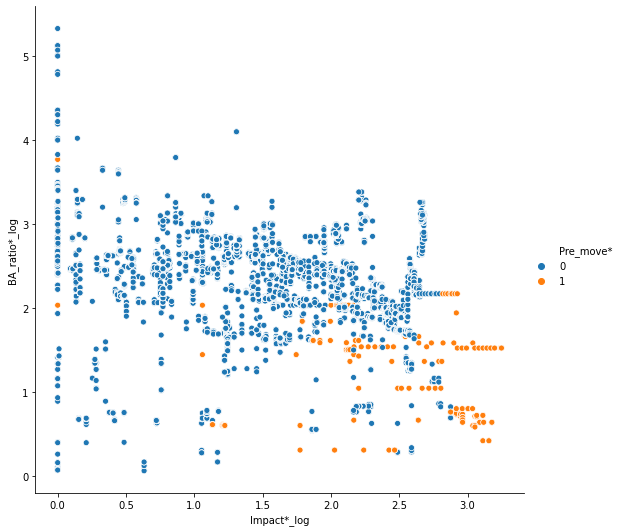

In [ ]:
# 4단계 : 관찰 대상 시간내의 호가 및 체결 정보를 산점도로 출력
#    호가변동 직전 상태는 "2" , 그 외 "0"

fil_con2 = after_stime & before_etime 
sns.relplot(x = 'Impact*_log', y = 'BA_ratio*_log', data = df[fil_con2], hue = 'Pre_move*', height = 7.5)


In [ ]:
from google.colab import files
#files.download('df0.csv')
#files.download('df1.csv')
files.download('df2.csv')